<a href="https://colab.research.google.com/github/Anu-vibes/text-emotion-analysis/blob/main/CNN_LSTM_dataset2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import nltk
import string
nltk.download('punkt')
# text preprocessing
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
import re, sys, os, csv

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# preparing input to our model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM,GRU, Dense

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Number of labels: joy, anger, fear, sadness, neutral
num_classes = 6

# Number of dimensions for word embedding
embed_num_dims = 100

# Max input length (max number of words)
max_seq_len = 200

class_names = ['sadness','joy', 'love', 'anger', 'fear','surprise']

In [4]:
from sklearn.model_selection import train_test_split
data2 = pd.read_csv('/content/drive/MyDrive/data2.csv', encoding='utf-8')
X_train, X_test, y_train, y_test = train_test_split(data2.text, data2.label, test_size=0.2, random_state=42)

In [5]:
data = data2
d = pd.concat([X_train, X_test], ignore_index=True)

In [6]:
tokenized_sentences = [sentence.split(" ") for sentence in d]
longest_sen = max(tokenized_sentences, key=len)
longest_sen_length = len(longest_sen)
shortest_sen = min(tokenized_sentences, key=len)
shortest_sen_length = len(shortest_sen)

print("Longest sentence:", longest_sen)
print("Length of longest sentence:", longest_sen_length)
print("Shortest sentence:", shortest_sen)
print("Length of shortest sentence:", shortest_sen_length)

Longest sentence: ['a', 'few', 'days', 'back', 'i', 'was', 'waiting', 'for', 'the', 'bus', 'at', 'the', 'bus', 'stop', 'before', 'getting', 'into', 'the', 'bus', 'i', 'had', 'prepared', 'the', 'exact', 'amount', 'of', 'coins', 'to', 'pay', 'for', 'the', 'bus', 'fair', 'and', 'when', 'i', 'got', 'into', 'the', 'bus', 'i', 'put', 'these', 'coins', 'into', 'the', 'box', 'meant', 'to', 'collect', 'the', 'bus', 'fair', 'i', 'thought', 'that', 'i', 'had', 'paid', 'and', 'wanted', 'to', 'get', 'inside', 'however', 'the', 'bus', 'driver', 'called', 'me', 'and', 'asked', 'me', 'in', 'an', 'impolite', 'way', 'if', 'the', 'coins', 'were', 'stuck', 'at', 'the', 'opening', 'of', 'the', 'box', 'he', 'had', 'not', 'seen', 'me', 'paying', 'and', 'there', 'wasnt', 'a', 'stack', 'of', 'coins', 'in', 'the', 'box', 'i', 'could', 'not', 'understand', 'this', 'and', 'the', 'driver', 'kept', 'questioning', 'me', 'he', 'made', 'me', 'feel', 'angry', 'and', 'at', 'last', 'i', 'inserted', 'a', 'dollar', 'coin',

In [7]:
print(data.label.value_counts())
data.head(100)

label
1    141067
0    121187
3     57317
4     47712
2     34554
5     14972
Name: count, dtype: int64


,text,label
0,i feel awful about it too because it s my job ...,0
1,im alone i feel awful,0
2,ive probably mentioned this before but i reall...,1
3,i was feeling a little low few days back,0
4,i beleive that i am much more sensitive to oth...,2
...,...,...
95,i really liked it and i have a feeling the bel...,1
96,i feel like talking in a snobbish uppity accen...,3
97,i don t feel as needy and desperate to prove t...,0
98,i feel bad for my mum who carries everything a...,0


In [8]:
def clean_text(data):

    # remove hashtags and @usernames
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    data = re.sub(r'[^\w\s]','', data)
    data = re.sub(r'\d','',data)

    # tokenization using nltk
    data = data.lower()
    data = word_tokenize(data)
    stop_words = set(stopwords.words('english'))
    data = [word for word in data if word not in stop_words]
    stemmer = PorterStemmer()
    data = [stemmer.stem(word) for word in data]
    lemmatizer = WordNetLemmatizer()
    data = [lemmatizer.lemmatize(word) for word in data]
    return data

In [9]:
texts = [' '.join(clean_text(text)) for text in data.text]

texts_train = [' '.join(clean_text(text)) for text in X_train]
texts_test = [' '.join(clean_text(text)) for text in X_test]

In [10]:
print(texts_train[4])

feel wit sincer


In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(d)

sequence_train = tokenizer.texts_to_sequences(X_train)
sequence_test = tokenizer.texts_to_sequences(X_test)

index_of_words = tokenizer.word_index

# vacab size is number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 75302


In [12]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[   0,    0,    0, ...,   34,    5,  116],
       [   0,    0,    0, ...,    7, 3322,  471],
       [   0,    0,    0, ...,    2,   46, 1197],
       ...,
       [   0,    0,    0, ..., 2168,  103, 1410],
       [   0,    0,    0, ...,  194,    4,  121],
       [   0,    0,    0, ...,   27,  116,   61]], dtype=int32)

In [13]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [15]:
def create_embedding_matrix1(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(values[1:], dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [16]:
embedd_matrix = create_embedding_matrix1('/content/drive/MyDrive/glove.twitter.27B.100d_wv.txt', index_of_words, embed_num_dims)
embedd_matrix.shape

(75303, 100)

In [17]:

# Inspect unseen words
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 56041
New words found: 19261


In [18]:
# Embedding layer before the actaul LSTM
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

In [19]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Parameters
lstm_output_size = 128
bidirectional = True

# Define the model
model = Sequential()

# Add the embedding layer
model.add(embedd_layer)

# Add the Convolutional layers
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Add LSTM or biLSTM layer
if bidirectional:
    model.add(Bidirectional(LSTM(units=lstm_output_size,
                                  dropout=0.2,
                                  recurrent_dropout=0.2)))
else:
    model.add(LSTM(units=lstm_output_size,
                   dropout=0.2,
                   recurrent_dropout=0.2))

# Add Dense layer and output layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          7530300   
                                                                 
 conv1d (Conv1D)             (None, 200, 64)           19264     
                                                                 
 max_pooling1d (MaxPooling1  (None, 100, 64)           0         
 D)                                                              
                                                                 
 bidirectional (Bidirection  (None, 256)               197632    
 al)                                                             
                                                                 
 dense (Dense)               (None, 6)                 1542      
                                                                 
Total params: 7748738 (29.56 MB)
Trainable params: 21843

In [20]:
ubatch_size = 128
epochs = 4

hist = model.fit(X_train_pad, y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

Epoch 1/4
2606/2606 [==============================] - 3371s 1s/step - loss: 0.4251 - accuracy: 0.8379 - val_loss: 0.1589 - val_accuracy: 0.9231
Epoch 2/4
2606/2606 [==============================] - 3364s 1s/step - loss: 0.1565 - accuracy: 0.9246 - val_loss: 0.1262 - val_accuracy: 0.9310
Epoch 3/4
2606/2606 [==============================] - 3324s 1s/step - loss: 0.1282 - accuracy: 0.9308 - val_loss: 0.1131 - val_accuracy: 0.9330
Epoch 4/4
2606/2606 [==============================] - 3345s 1s/step - loss: 0.1170 - accuracy: 0.9339 - val_loss: 0.1097 - val_accuracy: 0.9346


In [21]:
model.save('/content/drive/My Drive/CNN-LSTM-dataset2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


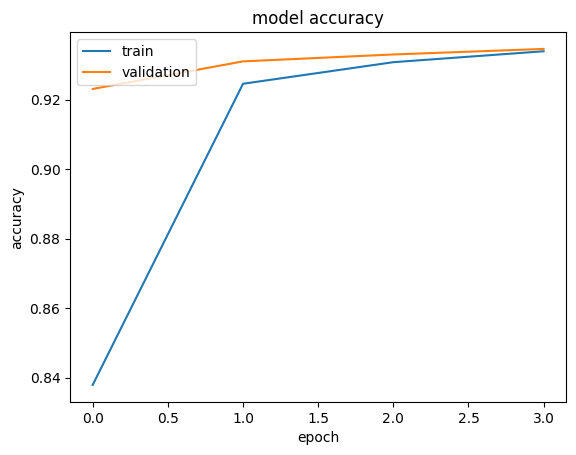

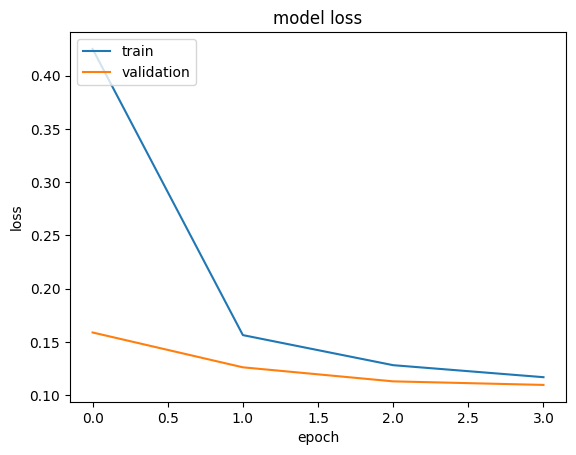

In [22]:
#  "Accuracy"
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [29]:
from keras.models import load_model
predictor = load_model('/content/drive/My Drive/CNN-LSTM-dataset2.h5')